In [1]:
%matplotlib notebook

In [2]:
import os
import shutil
import numpy as np
import argparse
import errno
import tensorboardX
from time import time
import random
import prettytable
import traceback
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from itertools import cycle
from collections import Counter
import importlib

from lib.utils.tools import *
from lib.utils.learning import *
from lib.data.datareader_h36m import DataReaderH36M
from lib.data.dataset import MotionDataset3D
from lib.data.dataset_2DAR import ActionRecognitionDataset2D, get_AR_labels, collate_fn_2DAR
from lib.model.loss import *
from lib.utils.viz_skel_seq import viz_skel_seq_anim

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from lib.utils.utils_AR import get_targets

In [3]:
def import_class(class_name):
    mod_str, _sep, class_str = class_name.rpartition('.')
    __import__(mod_str)
    try:
        return getattr(sys.modules[mod_str], class_str)
    except AttributeError:
        raise ImportError('Class %s cannot be found (%s)' % (class_str, traceback.format_exception(*sys.exc_info())))


def import_function(func_name=None):
    """
    动态导入指定的函数。
    
    参数:
    - func_name: 一个字符串，表示函数的全限定名，如 "mymodule.my_function"
    
    返回:
    - 导入的函数对象
    """    
    # 分割模块名和函数名
    module_name, func_name = func_name.rsplit('.', 1)
    
    # 动态导入模块
    module = importlib.import_module(module_name)
    
    # 获取函数对象
    func = getattr(module, func_name)
    
    return func


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--config", type=str, default="configs/default.yaml", help="Path to the config file.")
    parser.add_argument('-c', '--checkpoint', default='ckpt/default', type=str, metavar='PATH', help='checkpoint directory')
    parser.add_argument('-r', '--resume', default='', type=str, metavar='FILENAME', help='checkpoint to resume (file name)')
    parser.add_argument('-e', '--evaluate', default='', type=str, metavar='FILENAME', help='checkpoint to evaluate (file name)')
    parser.add_argument('-sd', '--seed', default=0, type=int, help='random seed')
    parser.add_argument('-v', '--visualize', action='store_true', help='whether to activate visualization')
    opts, _ = parser.parse_known_args()
    return opts

In [4]:
def create_pose(ax, plots, vals, colors_list, update=False, if_node=False, if_origin=False, lw=2, if_target=False, if_ntu=False):
    if not if_ntu:
        connect = [(0,1), (1,2), (2,3),       (0,4), (4,5), (5,6),      (0,7), (7,8), (8,9), (9,10),
                (8,14), (14,15), (15,16),      (8,11), (11,12), (12,13), ]

        LR = [True, True, True,      False, False, False,        True, True, True, True,
            True, True, True,      False, False, False]

    else: 
        connect = [(0,1), (1,20), (20,2), (2,3), 
                   (20,4), (4,5), (5,6), (6,7), (7,21), (7,22), 
                   (20,8), (8,9), (9,10), (10,11), (11,23), (11,24), 
                   (0,16), (16,17), (17,18), (18,19), 
                   (0,12), (12,13), (13,14), (14,15)]
        LR = [True, True, True, True,
              False, False, False, False, False, False,
              True, True, True, True, True, True,
              False, False, False, False,
              True, True, True, True]
    
    LR = [not sign for sign in LR]

    # Start and endpoints of our representation
    I = np.array([touple[0] for touple in connect])
    J = np.array([touple[1] for touple in connect])
    LR = np.array(LR)


    for vals_per_task_idx, task in enumerate(vals):
        vals_per_task = vals[task]
        colors_per_task = colors_list[vals_per_task_idx]
        for bone_idx in np.arange(len(I)):
            x = np.array([vals_per_task[I[bone_idx], 0], vals_per_task[J[bone_idx], 0]])
            y = np.array([vals_per_task[I[bone_idx], 1], vals_per_task[J[bone_idx], 1]])
            z = np.array([vals_per_task[I[bone_idx], 2], vals_per_task[J[bone_idx], 2]])
            if not update:
                plots.append(ax.plot(x, y, z, lw=lw, linestyle='-', c=colors_per_task["lcolor"] if LR[bone_idx] else colors_per_task["rcolor"], label=task if bone_idx==0 else ''))
            elif update:
                plots[vals_per_task_idx*(len(I)+1) + bone_idx][0].set_xdata(x)
                plots[vals_per_task_idx*(len(I)+1) + bone_idx][0].set_ydata(y)
                plots[vals_per_task_idx*(len(I)+1) + bone_idx][0].set_3d_properties(z)
                plots[vals_per_task_idx*(len(I)+1) + bone_idx][0].set_color(colors_per_task["lcolor"] if LR[bone_idx] else colors_per_task["rcolor"])

    
        colors = ['gray' for _ in range(17)] if not if_ntu else ['gray' for _ in range(25)]
        sizes = [1 for _ in range(17)] if not if_ntu else [1 for _ in range(25)]
        vals_per_task = np.concatenate((vals_per_task, np.zeros((1,3))), axis=0)      # (17,3)||(1,3)->(18,3)
        colors.append('black')
        sizes.append(30)

        if if_node and if_origin:
            if not update:
                plots.append(ax.scatter(vals_per_task[:, 0], vals_per_task[:, 1], vals_per_task[:, 2], c=colors, s=sizes))
            elif update:
                plots[vals_per_task_idx*(len(I)+1) + len(I)]._offsets3d = (vals_per_task[:, 0], vals_per_task[:, 1], vals_per_task[:, 2])
        elif if_node:
            if not update:
                plots.append(ax.scatter(vals_per_task[:-1, 0], vals_per_task[:-1, 1], vals_per_task[:-1, 2], c=colors[:-1], s=sizes[:-1]))
            elif update:
                plots[vals_per_task_idx*(len(I)+1) + len(I)]._offsets3d = (vals_per_task[:-1, 0], vals_per_task[:-1, 1], vals_per_task[:-1, 2])
        elif if_origin:
            if not update:
                plots.append(ax.scatter(vals_per_task[-1:, 0], vals_per_task[-1:, 1], vals_per_task[-1:, 2], c=colors[-1], s=sizes[-1]))
            elif update:
                plots[vals_per_task_idx*(len(I)+1) + len(I)]._offsets3d = (vals_per_task[-1:, 0], vals_per_task[-1:, 1], vals_per_task[-1:, 2])
        else:
            if not update:
                plots.append(ax.scatter(vals_per_task[-1:, 0], vals_per_task[-1:, 1], vals_per_task[-1:, 2], c=colors[-1], s=0.5))
            elif update:
                plots[vals_per_task_idx*(len(I)+1) + len(I)]._offsets3d = (vals_per_task[-1:, 0], vals_per_task[-1:, 1], vals_per_task[-1:, 2])

    return plots


def update(num, data, plots, fig, ax, fig_title, ttl, colors_list, if_node, if_origin, lim3d=1, lw=2, if_target=False, if_ntu=False):
    # vals = data[num]
    vals = {}
    for key in data:
        vals[key] = data[key][num]

    plots = create_pose(ax, plots, vals, colors_list, update=True, if_node=if_node, if_origin=if_origin, lw=lw, if_target=if_target, if_ntu=if_ntu)
    # r = 0.4
    # xroot, zroot, yroot = vals[0, 0], vals[0, 1], vals[0, 2]
    # ax.set_xlim3d([-r + xroot, r + xroot])
    # ax.set_ylim3d([-r + yroot, r + yroot])
    # ax.set_zlim3d([-r + zroot, r + zroot])
    ax.set_xlim3d([-1*lim3d, 1*lim3d])
    ax.set_ylim3d([-1*lim3d, 1*lim3d])
    ax.set_zlim3d([-1*lim3d, 1*lim3d])


    if if_target:
        targets = get_targets().data.cpu().numpy()
        ax.scatter(targets[:, 0], targets[:, 1], targets[:, 2], c='gray', s=5)
        # if not update:
        #     plots.append(ax.scatter(targets[:, 0], targets[:, 1], targets[:, 2], c='gray', s=5))
        # else:
        #     plots[-1]._offsets3d(targets[:, 0], targets[:, 1], targets[:, 2])


    # ax.set_title(fig_title+f" | frame {num+1}")
    ttl.set_text(fig_title+f" | frame {num+1}")

    ax.legend(loc='upper right')

    return plots

In [5]:
opts = parse_args()
args = get_config(opts.config)

# Import specified classes and functions
## dataset AR
dataset_action_recognition_VER = args.func_ver.get('dataset_action_recognition', 1)
dataset_action_recognition = import_class(class_name=f'funcs_and_classes.dataset_AR.ver{dataset_action_recognition_VER}.Dataset_ActionRecognition')
## evaluate AR
evaluate_action_recognition_VER = args.func_ver.get('evaluate_action_recognition', 2)
evaluate_action_recognition = import_function(func_name=f'funcs_and_classes.eval_AR.ver{evaluate_action_recognition_VER}.evaluate_action_recognition')
## train epoch
train_epoch_VER = args.func_ver.get('train_epoch', 2)
train_epoch = import_function(func_name=f'funcs_and_classes.train_epoch.ver{train_epoch_VER}.train_epoch')
    

In [6]:
# "#9b59b6"紫色, "#2ecc71"绿色
colors_list = [
    {"lcolor": "#9b59b6", "rcolor": "#2ecc71"},    # 紫+绿
    {"lcolor": np.array([197, 90, 17])/255, "rcolor": np.array([244, 177, 131])/255},    # PE 橙色
    {"lcolor": np.array([0, 176, 240])/255, "rcolor": np.array([157, 195, 230])/255},     # AR 蓝色
    {"lcolor": np.array([146, 208, 80])/255, "rcolor": np.array([197, 224, 180])/255},      # MP 绿色
    {"lcolor": np.array([112, 48, 160])/255, "rcolor": np.array([192, 151, 224])/255},     # 备用 紫色
    {"lcolor": np.array([255, 0, 0])/255, "rcolor": np.array([255, 129, 129])/255},     # 备用 红色
    {"lcolor": np.array([255, 192, 0])/255, "rcolor": np.array([255, 230, 153])/255},     # 备用 黄色
    {"lcolor": 'brown', "rcolor": 'brown'},     
    {"lcolor": 'green', "rcolor": 'green'},   
    {"lcolor": 'blue', "rcolor": 'blue'},     
    {"lcolor": 'yellow', "rcolor": 'yellow'},  
    {"lcolor": 'gray', "rcolor": 'black'},
]

In [7]:
def get_data(data, if_rot):
    if isinstance(data, np.ndarray):
        frame_n = data.shape[0]

        if if_rot:
            tmp = np.zeros_like(data)
            tmp[..., 0] = data[..., 2]
            tmp[..., 1] = data[..., 0]
            tmp[..., 2] = - data[..., 1]
            data = tmp

        data = {"unnamed key": data}
    elif isinstance(data, torch.Tensor):
        data = data.detach().cpu().numpy()

        if if_rot:
            tmp = np.zeros_like(data)
            tmp[..., 0] = data[..., 2]
            tmp[..., 1] = data[..., 0]
            tmp[..., 2] = - data[..., 1]
            data = tmp

        frame_n = data.shape[0]
        data = {"unnamed key": data}
    elif isinstance(data, dict):
        if isinstance(data[list(data.keys())[0]], torch.Tensor):
            data = {key: value.detach().cpu().numpy() for key, value in data.items()}
        frame_n = data[list(data.keys())[0]].shape[0]

        if if_rot:
            for key, value in data.items():
                tmp = np.zeros_like(value)
                tmp[..., 0] = value[..., 2]
                tmp[..., 1] = value[..., 0]
                tmp[..., 2] = - value[..., 1]
                data[key] = tmp
    else:
        raise ValueError('Unsupported input type. (Supported types: np.ndarray, torch.Tensor, dict)')
    return data, frame_n

In [8]:
if_ntu=True; if_print=False; if_node=False; if_origin=False; fig_title="unname"; file_name=None; file_folder=None; lim3d=1; lw=2; if_rot=False; fs=1; azim=40; elev=40; file_type='gif'; mp4_fps=10; if_target=False

In [9]:
train_dataset_AR = dataset_action_recognition(**args.train_feeder_args_ntu)

In [10]:
data = train_dataset_AR.data
data.shape

(40091, 3, 300, 25, 2)

In [11]:
valid_frames_list = []
for b in range(40091):
    d = data[b] # (3,300,25,2)
    valid_frames = np.where(d.sum(0).sum(-1).sum(-1) != 0)[0]
    valid_frames_list.append(valid_frames)

<IPython.core.display.Javascript object>


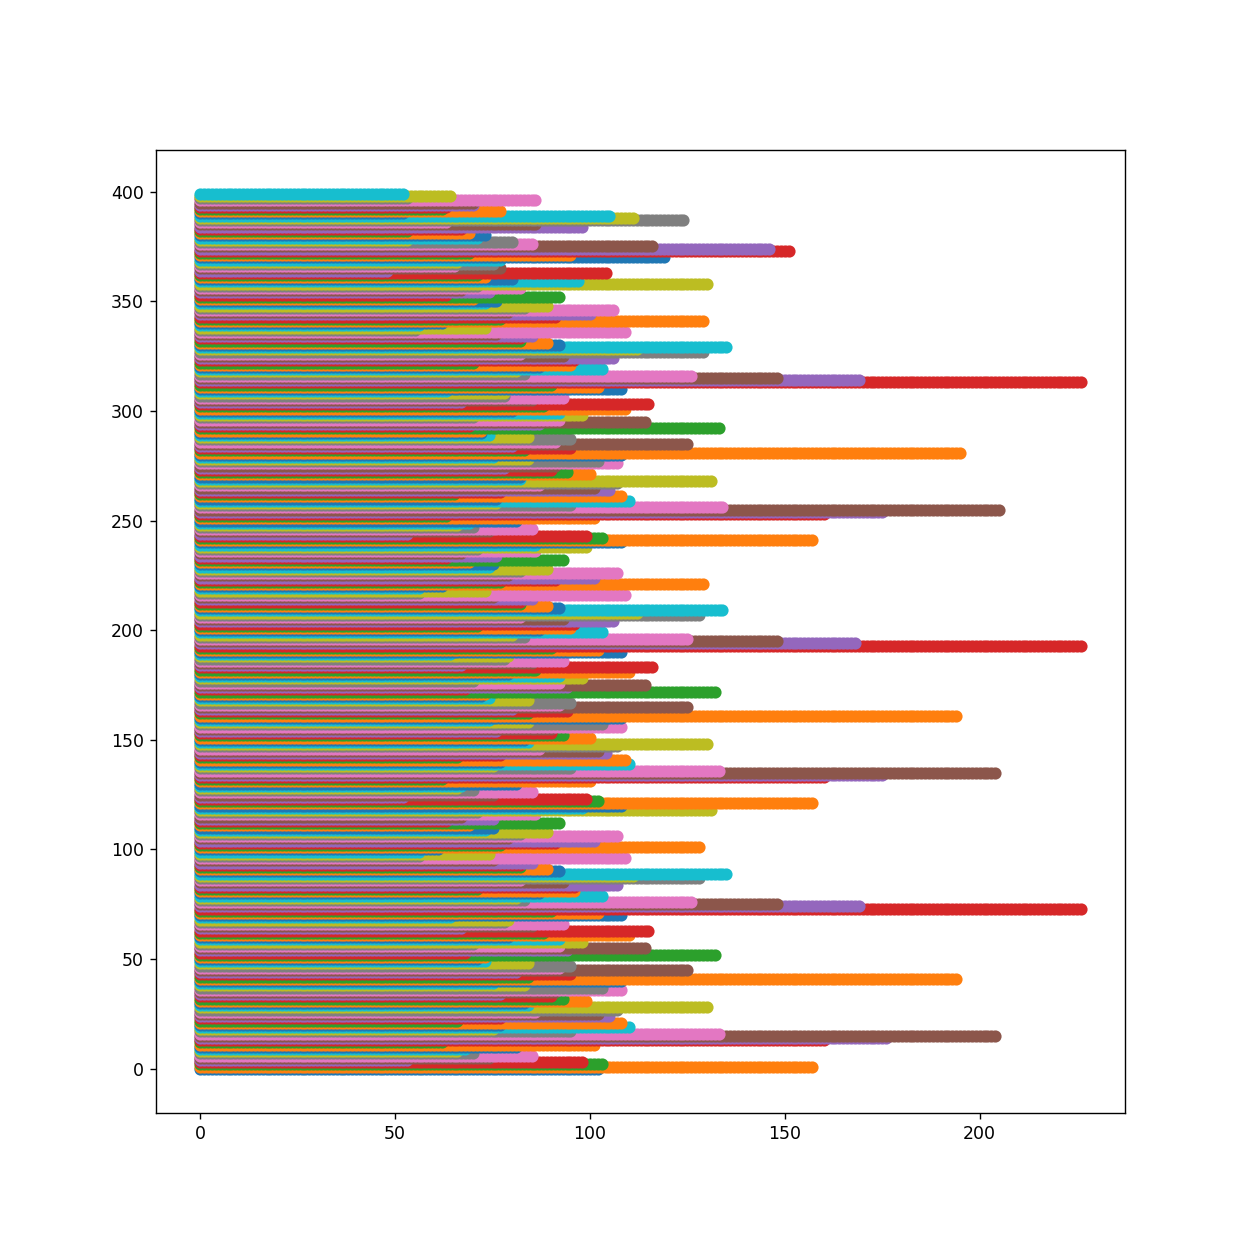

!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!


In [20]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()
for b in range(400):
    if valid_frames_list[b][0] == 0 and False:
        continue
    print('!')
    valid_frames = valid_frames_list[b]
    ax.scatter(valid_frames, [b for _ in range (len(valid_frames))])
plt.show()

In [10]:
# test_dataset_AR = dataset_action_recognition(prompt_data=train_dataset_AR.data, prompt_label=train_dataset_AR.label, **args.test_feeder_args_ntu)

In [18]:
qi, ql, pi, pl = train_dataset_AR[0]
data = qi[0, :, : :]
data, frame_n = get_data(data, if_rot)

<IPython.core.display.Javascript object>


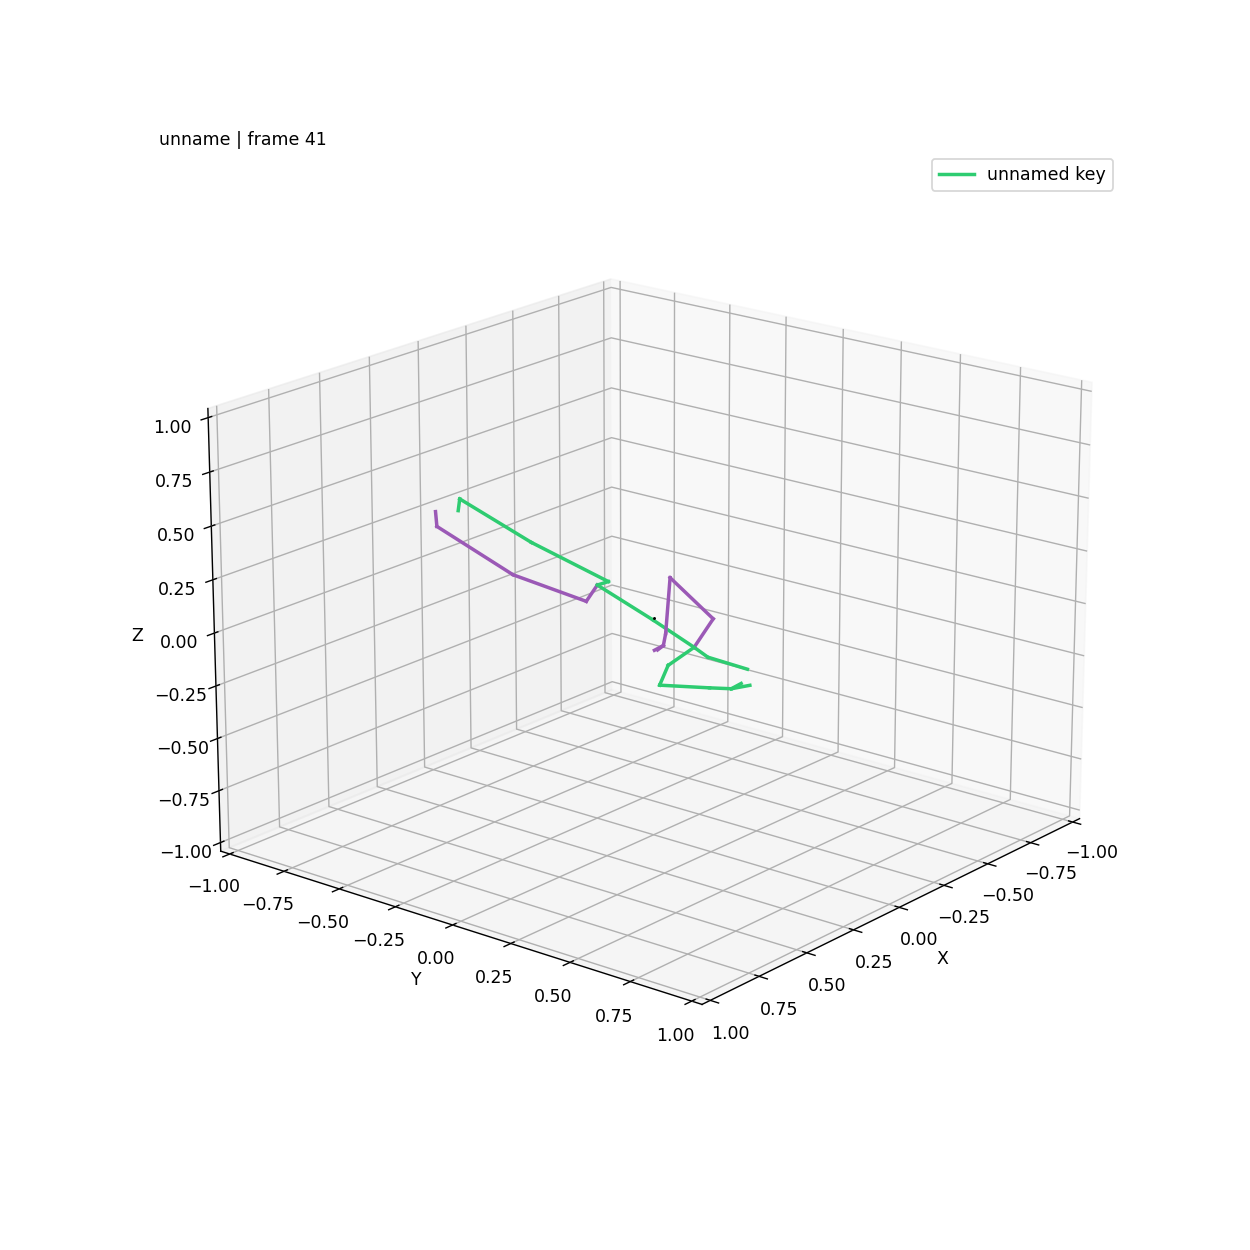

In [19]:
fig = plt.figure(figsize=(10*fs, 10*fs))
ax = plt.axes(projection='3d')
ax.view_init(azim=azim, elev=elev)
# ax.set_xlim3d([-1, 1.5])
# ax.set_ylim3d([-1, 1.5])
# ax.set_zlim3d([0.0, 1.5])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ttl = ax.text2D(0, 1.005, '', transform = ax.transAxes)      # Placement 0, 0 would be the bottom left, 1, 1 would be the top right.)

# vals = np.zeros((17, 3))  # or joints_to_consider
vals = {}
for key in data:
    vals[key] = np.zeros((17,3)) if not if_ntu else np.zeros((25,3))
plots = []
plots = create_pose(ax, plots, vals, colors_list, update=False, if_node=if_node, if_origin=if_origin, lw=lw, if_target=if_target, if_ntu=if_ntu)

line_anim = animation.FuncAnimation(fig, update, frame_n, fargs=(data, plots, fig, ax, fig_title, ttl, colors_list, if_node, if_origin, lim3d, lw, if_target, if_ntu), interval=400, blit=False)